In [141]:
import cv2
import numpy as  np
import matplotlib.pyplot as plt
import math

In [142]:
# set directories and project global variables

# training data for young_adult and adult
train_face_young_adult_dir = "training-young-adult/"
train_face_adult_dir = "training-adult/"

# testing data for young_adult and adult
test_face_young_adult_dir = "testing-young-adult/"
test_face_adult_dir = "testing-adult/"

train_img_count = 176
test_img_count = 59
img_length = 0
train_face_young_adult_images = []
train_face_adult_images = []
test_face_young_adult_images = []
test_face_adult_images = []

In [143]:
# TRAINING 

# load face young_adult training images
for i in range(1, train_img_count+1):
    image = cv2.imread(train_face_young_adult_dir+f"img-{i:03d}"+'.png') #read
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    img_length = image.shape[0] * image.shape[1] * image.shape[2]
    image = image.reshape(img_length) #vectorize
    train_face_young_adult_images.append(image)

# load face adult training images
for i in range(1, train_img_count+1):
    image = cv2.imread(train_face_adult_dir+f"img-{i:03d}"+'.png') #read
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    img_length = image.shape[0] * image.shape[1] * image.shape[2]
    image = image.reshape(img_length) #vectorize
    train_face_adult_images.append(image)
    
# storage for variance
face_young_adult_variances = np.zeros(img_length)
face_young_adult_means = np.zeros(img_length)
face_adult_variances = np.zeros(img_length)
face_adult_means = np.zeros(img_length)

# Calculate the mean for face images
for image in train_face_young_adult_images:
    face_young_adult_means = np.add(face_young_adult_means, image)
face_young_adult_means = face_young_adult_means/train_img_count #divide by count

# Calculate the mean for background images
for image in train_face_adult_images:
    face_adult_means = np.add(face_adult_means, image)
face_adult_means = face_adult_means/train_img_count #divide by count

# Calculate the variance for face images
for image in train_face_young_adult_images:
    difference = np.subtract(image, face_young_adult_means) # xi - avg(X)
    difference = np.power(difference, 2) # (xi - avg(X))^2
    face_young_adult_variances = np.add(face_young_adult_variances, difference) # Σ((xi - avg(X))^2)
face_young_adult_variances = face_young_adult_variances/train_img_count # Σ((xi - avg(X))^2) / N

# Calculate the variance for bg images
for image in train_face_adult_images:
    difference = np.subtract(image, face_adult_means) # xi - avg(X)
    difference = np.power(difference, 2) # (xi - avg(X))^2
    face_adult_variances = np.add(face_adult_variances, difference) # Σ((xi - avg(X))^2)
face_adult_variances = face_adult_variances/train_img_count # Σ((xi - avg(X))^2) / N  

In [144]:
# TESTING
face_young_adult_detected_count = 0
face_adult_detected_count = 0

# load face young_adult testing images
for i in range(1, test_img_count+1):
    image = cv2.imread(test_face_young_adult_dir+f"img-{i:02d}"+'.png') #read
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    image = image.reshape(img_length) #vectorize
    test_face_young_adult_images.append(image)

# load face adult testing images
for i in range(1, test_img_count+1):
    image = cv2.imread(test_face_adult_dir+f"img-{i:02d}"+'.png') #read
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    image = image.reshape(img_length) #vectorize
    test_face_adult_images.append(image)

# Predict face young_adult testing images
log_face_young_adult = np.log2(face_young_adult_variances[face_young_adult_variances != 0]) # lg(variance(D)) y=1
sum_log_face_young_adult = np.sum(log_face_young_adult) # Σ(lg(variance(D))) y=1
log_face_adult = np.log2(face_adult_variances[face_adult_variances != 0]) # lg(variance(D)) y=0
sum_log_face_adult = np.sum(log_face_adult) # Σ(lg(variance(D))) y=0

for image in test_face_young_adult_images:
    Pr_x_given_y_1 = np.subtract(image, face_young_adult_means) # X-M
    Pr_x_given_y_1 = np.power(Pr_x_given_y_1, 2) # (X-M)^2
    with np.errstate(divide='ignore', invalid='ignore'):
        Pr_x_given_y_1 = np.where(face_young_adult_variances != 0.0, np.divide(Pr_x_given_y_1, face_young_adult_variances*2), 0) # ((X-M)^2)/(2*variance(D))
    Pr_x_given_y_1 = np.sum(Pr_x_given_y_1) # Σ(((X-M)^2)/(2*variance(D)))
    # -1/2 * Σ(lg(variance(D))) - Σ(((X-M)^2)/(2*variance(D)))
    Pr_x_given_y_1 = (-0.5 * sum_log_face_young_adult) - Pr_x_given_y_1
    
    Pr_x_given_y_0 = np.subtract(image, face_adult_means) # X-M
    Pr_x_given_y_0 = np.power(Pr_x_given_y_0, 2) # (X-M)^2
    with np.errstate(divide='ignore', invalid='ignore'):
        Pr_x_given_y_0 = np.where(face_adult_variances !=0.0, np.divide(Pr_x_given_y_0, face_adult_variances*2), 0) # ((X-M)^2)/(2*variance(D))
    Pr_x_given_y_0 = np.sum(Pr_x_given_y_0) # Σ(((X-M)^2)/(2*variance(D)))
    # -1/2 * Σ(lg(variance(D))) - Σ(((X-M)^2)/(2*variance(D)))
    Pr_x_given_y_0 = (-0.5 * sum_log_face_adult) - Pr_x_given_y_0
    
    face_young_adult_detected_count = face_young_adult_detected_count + 1 if (Pr_x_given_y_1 > Pr_x_given_y_0) else face_young_adult_detected_count

print('BGR IMAGE TEST')
print("Face Young Adult detection accuracy: %0.2f%s" % (face_young_adult_detected_count/test_img_count*100, '%'))

for image in test_face_adult_images:
    Pr_x_given_y_1 = np.subtract(image, face_young_adult_means) # X-M
    Pr_x_given_y_1 = np.power(Pr_x_given_y_1, 2) # (X-M)^2
    with np.errstate(divide='ignore', invalid='ignore'):
        Pr_x_given_y_1 = np.where(face_young_adult_variances != 0.0, np.divide(Pr_x_given_y_1, face_young_adult_variances*2), 0) # ((X-M)^2)/(2*variance(D))
    Pr_x_given_y_1 = np.sum(Pr_x_given_y_1) # Σ(((X-M)^2)/(2*variance(D)))
    # -1/2 * Σ(lg(variance(D))) - Σ(((X-M)^2)/(2*variance(D)))
    Pr_x_given_y_1 = (-0.5 * sum_log_face_young_adult) - Pr_x_given_y_1
    
    Pr_x_given_y_0 = np.subtract(image, face_adult_means) # X-M
    Pr_x_given_y_0 = np.power(Pr_x_given_y_0, 2) # (X-M)^2
    with np.errstate(divide='ignore', invalid='ignore'):
        Pr_x_given_y_0 = np.where(face_adult_variances != 0.0, np.divide(Pr_x_given_y_0, face_adult_variances*2), 0) # ((X-M)^2)/(2*variance(D))
    Pr_x_given_y_0 = np.sum(Pr_x_given_y_0) # Σ(((X-M)^2)/(2*variance(D)))
    # -1/2 * Σ(lg(variance(D))) - Σ(((X-M)^2)/(2*variance(D)))
    Pr_x_given_y_0 = (-0.5 * sum_log_face_adult) - Pr_x_given_y_0
    
    face_adult_detected_count = face_adult_detected_count + 1 if (Pr_x_given_y_1 < Pr_x_given_y_0) else face_adult_detected_count

print("Face Adult detection accuracy: %0.2f%s" % (face_adult_detected_count/test_img_count*100, '%'))


BGR IMAGE TEST
Face Young Adult detection accuracy: 96.61%
Face Adult detection accuracy: 61.02%


AttributeError: 'AxesImage' object has no property 'reversed'

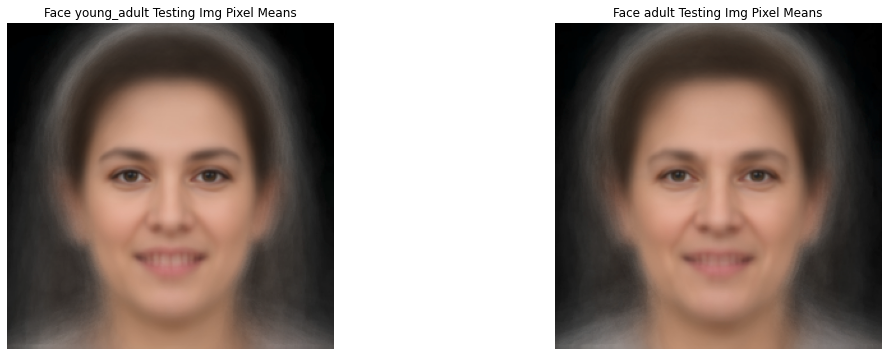

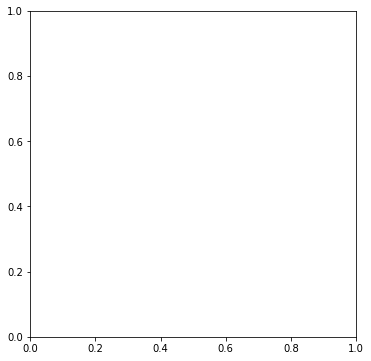

In [150]:
from matplotlib.colors import ListedColormap

### INTERMEDIATE FINDINGS DURING TRAINING PROCESS
face_young_adult_mean_display = face_young_adult_means
face_young_adult_mean_display = face_young_adult_mean_display.reshape(256, 256, 3)
face_adult_mean_display = face_adult_means
face_adult_mean_display = face_adult_mean_display.reshape(256, 256, 3)

face_young_adult_dev_display = np.sqrt(face_young_adult_variances)
face_young_adult_dev_display = face_young_adult_dev_display.reshape(256, 256, 3)
face_young_adult_dev_display = face_young_adult_dev_display.sum(axis=2)
face_young_adult_norm = np.linalg.norm(face_young_adult_dev_display)
face_young_adult_dev_display = face_young_adult_dev_display / face_young_adult_norm

face_adult_dev_display = np.sqrt(face_adult_variances)
face_adult_dev_display = face_adult_dev_display.reshape(256, 256, 3)
face_adult_dev_display = face_adult_dev_display.sum(axis=2)
face_adult_norm = np.linalg.norm(face_adult_dev_display)
face_adult_dev_display = face_adult_dev_display / face_adult_norm

reversed_cmap = ListedColormap(plt.cm.inferno.colors[::-1])

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(face_young_adult_mean_display.astype('uint8'), cv2.COLOR_LAB2RGB))
plt.title('Face young_adult Testing Img Pixel Means')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(face_adult_mean_display.astype('uint8'), cv2.COLOR_LAB2RGB))
plt.title('Face adult Testing Img Pixel Means')
plt.axis("off")

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.imshow(face_young_adult_dev_display, cmap=reversed_cmap, interpolation='nearest')
plt.title('Face young_adult Img Pixel Deviations')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(face_adult_dev_display, cmap=reversed_cmap, interpolation='nearest')
plt.title('Face adult Testing Img Pixel Deviations')
plt.axis("off")

plt.show()